In [211]:
import pandas as pd
import numpy as np
from numpy import var
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns


# loading the dataset
data = pd.read_csv('time_series_covid19_confirmed_global.csv')

# grouping by country/region column
country_level_data = data.groupby('Country/Region').sum(numeric_only=True).reset_index()

# add only the case columns for these rows
case_columns = country_level_data.columns[4:]
cases_by_country = country_level_data.groupby('Country/Region')[case_columns].sum()

# calculate total cases for each country due to the provinces/state
cases_by_country['Total Cases'] = cases_by_country[case_columns].iloc[:, -1]  # last column contains the latest cumulative data

# sort by total cases
sorted_cases = cases_by_country.sort_values(by='Total Cases', ascending=False)

top_3_countries = sorted_cases[['Total Cases']].head(3)

# formatting
top_3_countries['Total Cases'] = top_3_countries['Total Cases'].apply(lambda x: f"{x:,.0f}")

top_3_countries




,Total Cases
Country/Region,
US,"103,802,702"
India,"44,690,738"
France,"39,866,718"


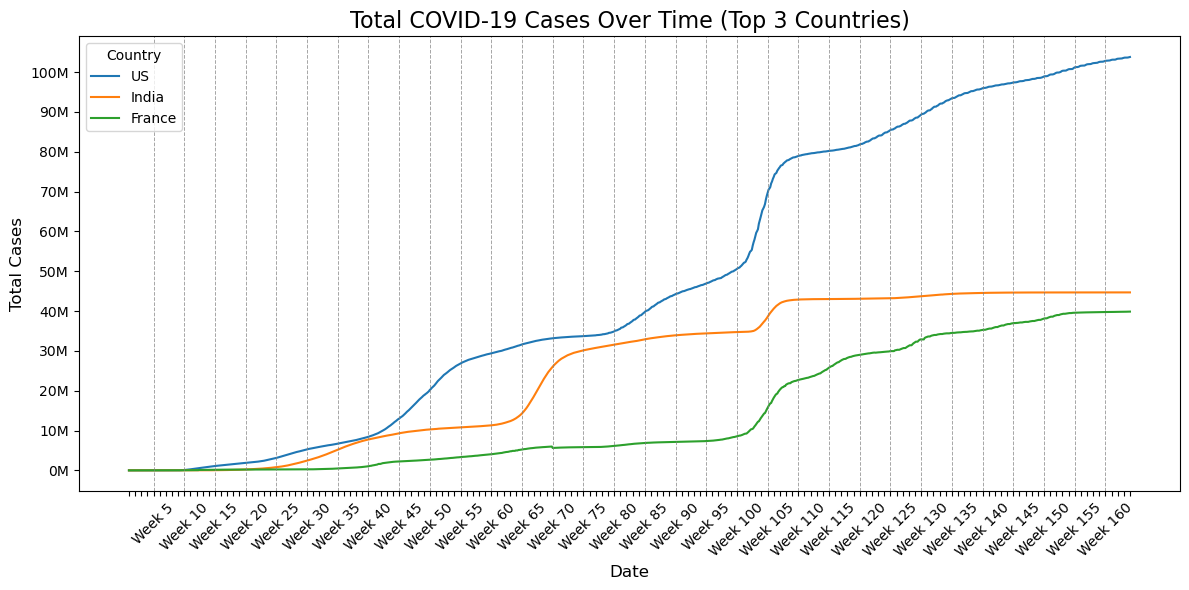

In [213]:


# filter the top 3 country data
top_countries = top_3_countries.index.tolist()
top_countries_data = country_level_data[country_level_data['Country/Region'].isin(top_countries)]
time_series_data = top_countries_data.set_index('Country/Region')[case_columns].T

# typecasting the date string to datetime
time_series_data.index = pd.to_datetime(time_series_data.index, format="%m/%d/%y")

# week numbers for labeling
time_series_data['Week Number'] = ((time_series_data.index - time_series_data.index[0]).days // 7) + 1

# plot the total cases over time
plt.figure(figsize=(12, 6))

# plotting lines
for country in top_countries:
    plt.plot(time_series_data.index, time_series_data[country], label=country)

# text labels
plt.title('Total COVID-19 Cases Over Time (Top 3 Countries)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Cases', fontsize=12)
plt.legend(title='Country', fontsize=10)

y_max = 103_000_000  # max value for total cases
y_ticks = range(0, y_max + 1, 10_000_000)  # ticks incrementin 10 millions
plt.yticks(ticks=y_ticks, labels=[f"{y // 1_000_000}M" for y in y_ticks])

# Generate ticks and labels for every 5th week. I don't know if matplotlib can do this natively
week_ticks = time_series_data[time_series_data['Week Number'].diff().fillna(1) > 0].index  # first day of each week
week_labels = [
    f"Week {int(week)}" if week % 5 == 0 else ""
    for week in time_series_data.loc[week_ticks, 'Week Number']
]

plt.xticks(ticks=week_ticks, labels=week_labels, rotation=45, fontsize=10)

# manually adding vertical grid lines for every 5th week
for tick in week_ticks:
    week_number = time_series_data.loc[tick, 'Week Number']
    if week_number % 5 == 0:
        plt.axvline(x=tick, color='gray', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.grid(visible=False)  # turn off default gridlines. having a line for each day/week was too messy.
plt.show()


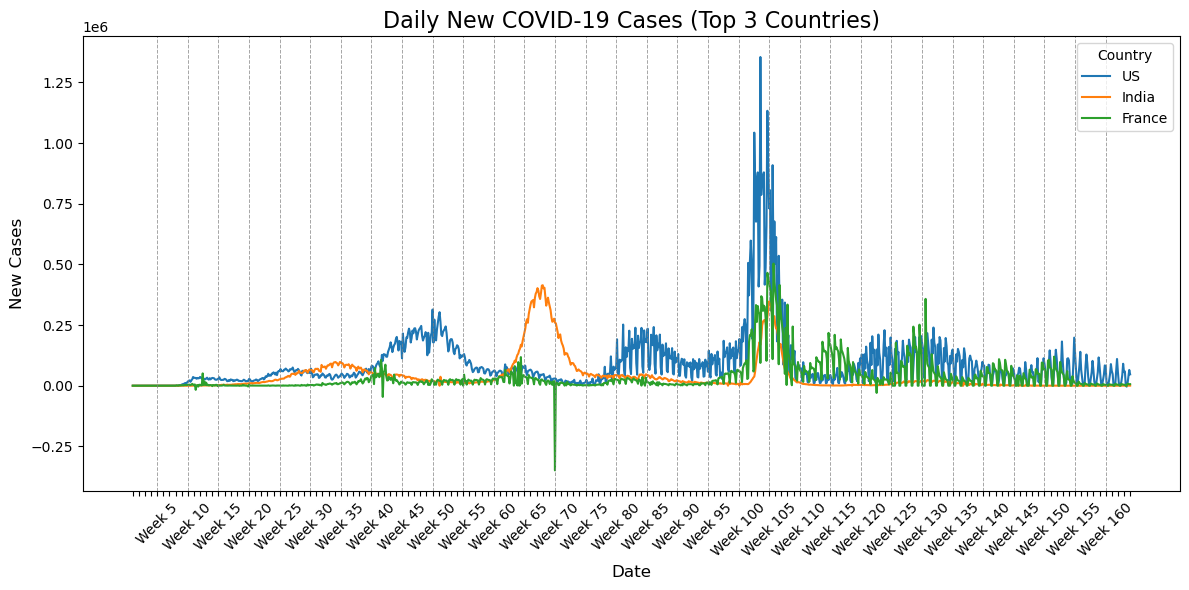

In [215]:
# calculate daily new cases
daily_new_cases = time_series_data.diff().fillna(0)

daily_new_cases['Week Number'] = ((daily_new_cases.index - daily_new_cases.index[0]).days // 7) + 1

# plot cases
plt.figure(figsize=(12, 6))
for country in top_countries:
    plt.plot(daily_new_cases.index, daily_new_cases[country], label=country)

# labels
plt.title('Daily New COVID-19 Cases (Top 3 Countries)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('New Cases', fontsize=12)
plt.legend(title='Country', fontsize=10)

# labels for every 5th week. same as before
week_ticks = daily_new_cases[daily_new_cases['Week Number'].diff().fillna(1) > 0].index 
week_labels = [
    f"Week {int(week)}" if week % 5 == 0 else ""
    for week in daily_new_cases.loc[week_ticks, 'Week Number']
]

plt.xticks(ticks=week_ticks, labels=week_labels, rotation=45, fontsize=10)

for tick in week_ticks:
    week_number = daily_new_cases.loc[tick, 'Week Number']
    if week_number % 5 == 0:
        plt.axvline(x=tick, color='gray', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.grid(visible=False)
plt.show()



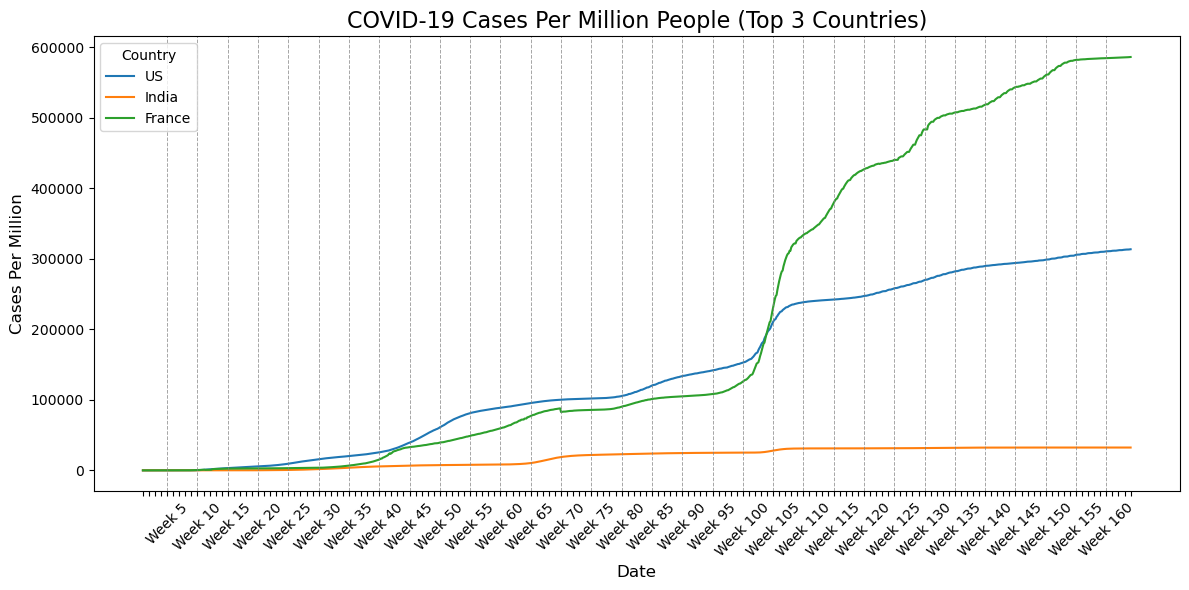

In [217]:
# Population data (estimate from Google)
population_data = {
    'US': 331_000_000,
    'India': 1_380_000_000,
    'France': 68_000_000
}

# normalize cases
cases_per_capita = time_series_data.copy()
for country in top_countries:
    cases_per_capita[country] = time_series_data[country] / population_data[country] * 1_000_000 

plt.figure(figsize=(12, 6))

for country in top_countries:
    plt.plot(cases_per_capita.index, cases_per_capita[country], label=country)

# Configure the plot
plt.title('COVID-19 Cases Per Million People (Top 3 Countries)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cases Per Million', fontsize=12)
plt.legend(title='Country', fontsize=10)

# TODO migrate to function
week_ticks = cases_per_capita[cases_per_capita['Week Number'].diff().fillna(1) > 0].index 
week_labels = [
    f"Week {int(week)}" if week % 5 == 0 else ""
    for week in cases_per_capita.loc[week_ticks, 'Week Number']
]

plt.xticks(ticks=week_ticks, labels=week_labels, rotation=45, fontsize=10)

for tick in week_ticks:
    week_number = cases_per_capita.loc[tick, 'Week Number']
    if week_number % 5 == 0:
        plt.axvline(x=tick, color='gray', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.grid(visible=False)
plt.show()




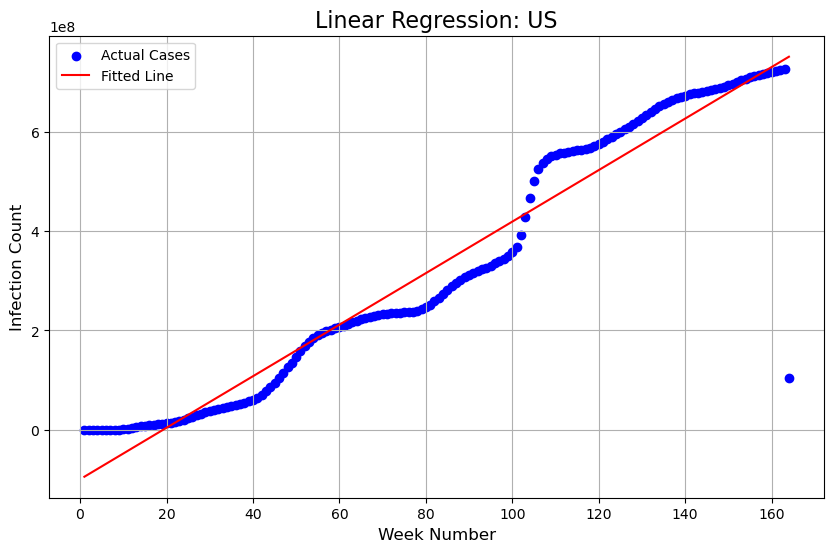

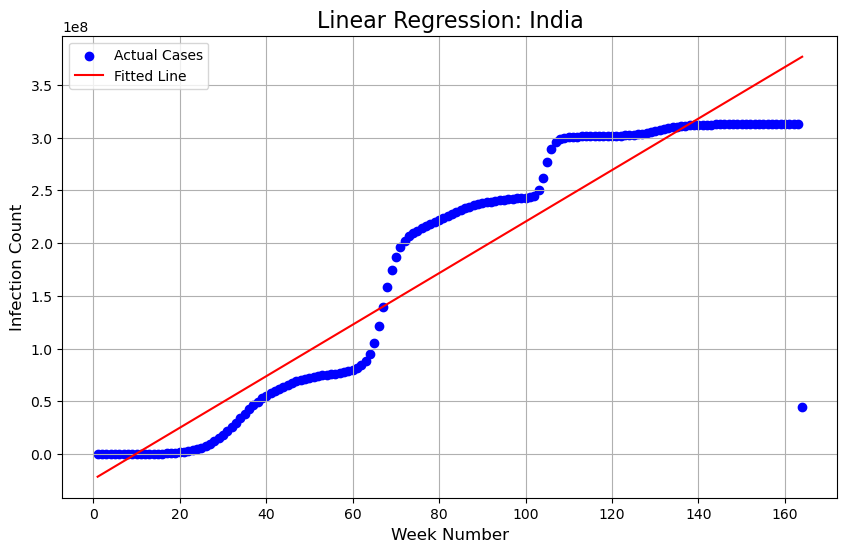

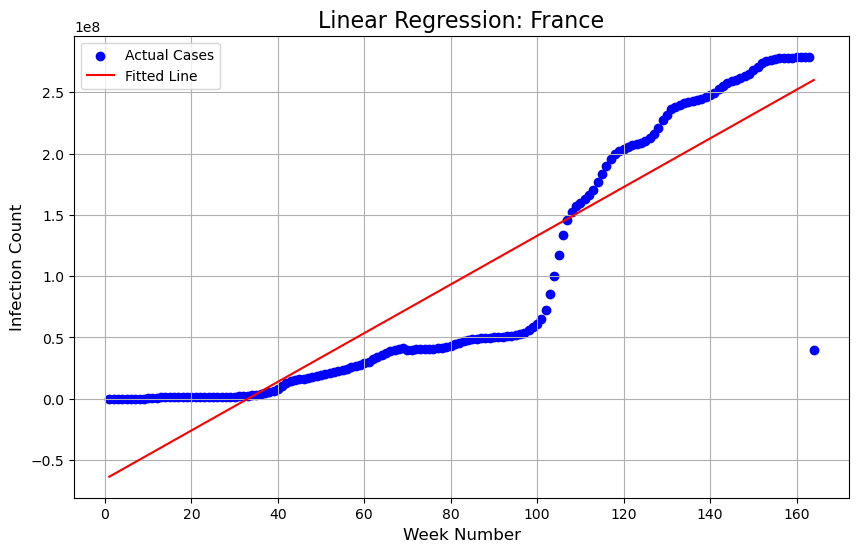

Regression Results with Variance:
  Country   Coefficient     Intercept      Variance
0      US  5.184961e+06 -9.963011e+07  4.669346e+15
1   India  2.442401e+06 -2.386932e+07  1.786669e+15
2  France  1.984583e+06 -6.552134e+07  1.695380e+15

Country with the Highest Variance:
Country                        US
Coefficient        5184961.016254
Intercept        -99630110.639758
Variance       4669345550533395.0
Name: 0, dtype: object


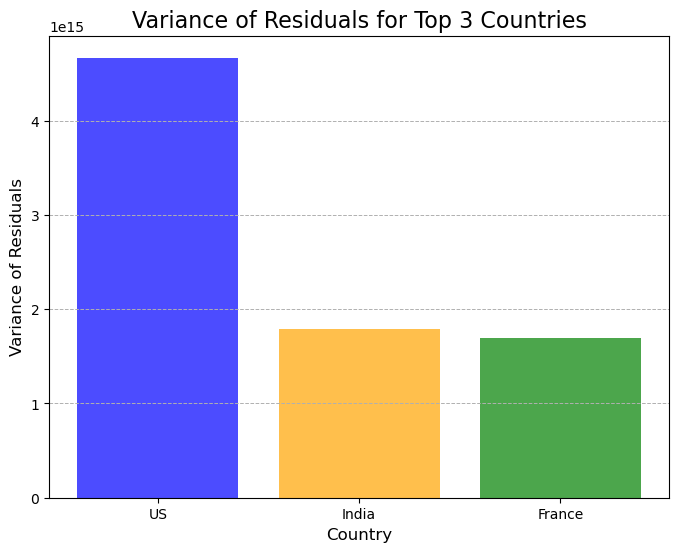

In [219]:
time_series_data['Week Number'] = ((time_series_data.index - time_series_data.index[0]).days // 7) + 1

weekly_data = time_series_data.groupby('Week Number').sum()

# Prepare for linear regression
X = weekly_data.index.values.reshape(-1, 1)  # Week numbers as independent variable
results = {}

# Fit a linear regression model for each country
for country in top_countries:
    y = weekly_data[country].values  # Weekly total cases as dependent variable
    
    # create and fit regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the model
    results[country] = {
        "model": model,
        "coef": model.coef_[0],
        "intercept": model.intercept_,
        "predictions": model.predict(X)
    }
    
    # Plot the actual vs predicted data
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual Cases')
    plt.plot(X, results[country]["predictions"], color='red', label='Fitted Line')
    plt.title(f"Linear Regression: {country}", fontsize=16)
    plt.xlabel("Week Number", fontsize=12)
    plt.ylabel("Infection Count", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()



# Compute residuals and variances for each country
variances = []
for country in top_countries:
    y = weekly_data[country].values
    predictions = results[country]["predictions"]
    residuals = y - predictions 
    variance = np.var(residuals) 
    variances.append(variance)

regression_results["Variance"] = variances

# country with the highest variance
highest_variance_country = regression_results.loc[
    regression_results["Variance"].idxmax()
]

# Print results
print("Regression Results with Variance:")
print(regression_results)

print("\nCountry with the Highest Variance:")
print(highest_variance_country)


# Plot
plt.figure(figsize=(8, 6))
plt.bar(top_countries, variances, color=['blue', 'orange', 'green'], alpha=0.7)
plt.title("Variance of Residuals for Top 3 Countries", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Variance of Residuals", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


C:\Users\jncro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jncro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jncro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jncro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

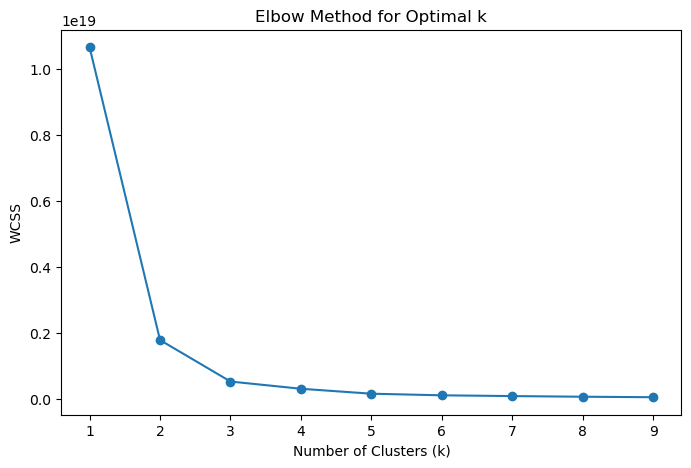

C:\Users\jncro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


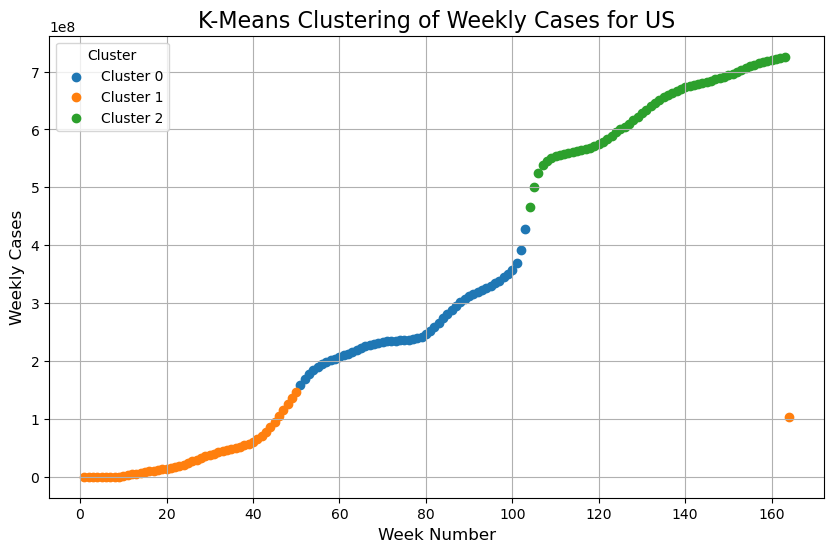

In [221]:
# Extract weekly cases
us_weekly_cases = weekly_data['US'].values.reshape(-1, 1)

# Determine clusters
# this portion generates warnings on my machine that require changing environment variables. I'll leave them in as I'd prefer not to modify it.
wcss = []  # within cluster sum of squares
for k in range(1, 10):  # Test cluster counts from 1 to 9
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init
    kmeans.fit(us_weekly_cases)
    wcss.append(kmeans.inertia_)

# Plot result
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means 
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  # Explicitly set n_init
cluster_labels = kmeans.fit_predict(us_weekly_cases)

# Add cluster labels
us_weekly_clustered = pd.DataFrame({
    'Week Number': weekly_data.index,
    'Weekly Cases': weekly_data['US'],
    'Cluster': cluster_labels
})

# Plot
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_data = us_weekly_clustered[us_weekly_clustered['Cluster'] == cluster]
    plt.scatter(cluster_data['Week Number'], cluster_data['Weekly Cases'], label=f'Cluster {cluster}')

plt.title('K-Means Clustering of Weekly Cases for US', fontsize=16)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Weekly Cases', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



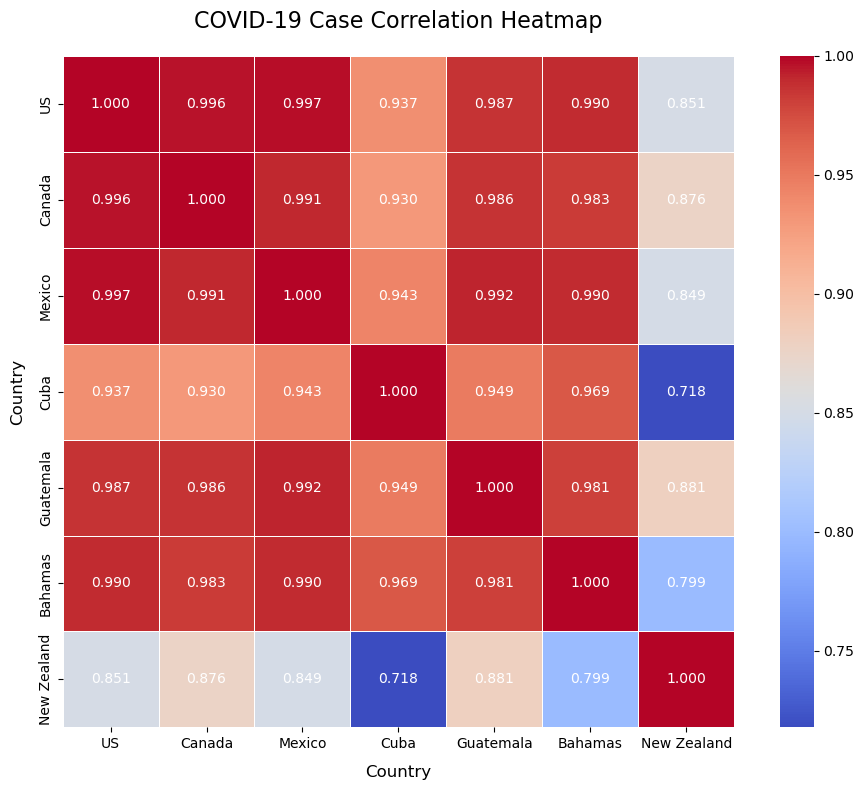

In [223]:

# Define countries of interest
countries_of_interest = ['US', 'Canada', 'Mexico', 'Cuba', 'Guatemala', 'Bahamas']
countries_of_interest = ['US', 'Canada', 'Mexico', 'Cuba', 'Guatemala', 'Bahamas', 'New Zealand'] # I overrode this to generate a heat-map with and without New Zealand, so this line needs to be removed or modified to remove new zealand
# Filter the data for these countries
filtered_data = cases_by_country.loc[countries_of_interest]

# Transpose and compute the correlation matrix
correlation_df = filtered_data.T.corr()  # Transpose so rows are countries and columns are dates.

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    correlation_df, 
    annot=False,         
    cmap="coolwarm",     
    linewidths=0.5,      # add gridlines between cells
    square=True          
)

# Couldn't get the lables to work properly, so adding manually.
for i in range(correlation_df.shape[0]):  # Iterate over rows
    for j in range(correlation_df.shape[1]):  # Iterate over columns
        text = f"{correlation_df.iloc[i, j]:.3f}"  # Format the correlation value
        heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', fontsize=10, color="white")

# Adjust labels
plt.title("COVID-19 Case Correlation Heatmap", fontsize=16, pad=20)
plt.xlabel("Country", fontsize=12, labelpad=10)
plt.ylabel("Country", fontsize=12, labelpad=10)

# Plot
plt.tight_layout()
plt.show()

